In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance

In [3]:
dataset = Dataset.load('../../data/parsed')
# df = pd.concat([dataset.fundamental, extract_market_data(dataset.market)], axis=1).dropna()

In [37]:
from datatools import calculate_market_return

m_df = extract_market_data(dataset.market)
market_return = calculate_market_return(m_df)
full_df = pd.concat([dataset.fundamental, m_df, dataset.ref_return], axis=1).merge(market_return, left_on='day', right_index=True).dropna()

In [46]:
full_df['res_return'] = full_df['return'] - ((1+full_df['market_return_0'].shift(-54*2).fillna(0))*(1+full_df['market_return_0'].shift(-54).fillna(0))-1)

In [76]:
from qids_lib import QIDS

qids = QIDS(path_prefix='../../')

In [101]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor


def easy_winsorize(s: Series, trim_ratio: float = 0.05):
    return np.clip(s, s.quantile(trim_ratio), s.quantile(1 - trim_ratio))


class DataPreprocessing:
    def __init__(self):
        self.scaler = RobustScaler()

    def unskew(self, X: DataFrame):
        df = DataFrame({
            'log_turnoverRatio': np.log(X['turnoverRatio']),
            'log_transactionAmount_pos': np.log(X['transactionAmount'] + 1),
            'log_pb': np.log(X['pb']),
            'log_ps': np.log(X['ps']),
            'log_volatility': np.log(X['volatility'] + 0.0001),
            'log_mean_volume': np.log(X['mean_volume'] + 1),
            # 'winsor_pe_ttm': X['pe_ttm'],
            'winsor_pe': X['pe'],
            'winsor_pcf': X['pcf'],
        })
        # for col in df.columns:
        #     df[col] = easy_winsorize(df[col])
        return df

    def fit_transform(self, X: DataFrame):
        unskewd_X = self.unskew(X)
        return DataFrame(self.scaler.fit_transform(unskewd_X), index=X.index, columns=unskewd_X.columns)
        # return DataFrame(self.scaler.fit_transform(self.unskew(X)), index=X.index, columns=X.columns)
        # return self.unskew(X)

    def transform(self, X: DataFrame):
        unskewd_X = self.unskew(X)
        return DataFrame(self.scaler.transform(unskewd_X), index=X.index, columns=unskewd_X.columns)
        # return DataFrame(self.transform(self.unskew(X)), index=X.index, columns=X.columns)
        # return self.unskew(X)


class SimpleLinearModel:
    def __init__(self):
        self.preprocess = DataPreprocessing()
        # self.reg = LinearRegression(fit_intercept=True)
        # self.reg = GaussianProcessRegressor()
        self.reg = KernelRidge(kernel='rbf', alpha=2)
        self.labels = None

    def fit_predict(self, X__, y):
        # res_return = X__['res_return']
        # if self.labels is None:
        #     self.labels = sorted(set(X__) - {'res_return'})
        # X = X__[self.labels]
        X_ = self.preprocess.fit_transform(X__)
        res_return = y - y.mean()
        # res_return = y
        self.reg.fit(X_, res_return)
        y_pred = self.reg.predict(X_)
        return y_pred

    def predict(self, X__):
        # X = X__[self.labels]
        X = X__
        X_ = self.preprocess.fit_transform(X)
        return self.reg.predict(X_)

In [102]:
model = SimpleLinearModel()
feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe', 'pcf', 'volatility', 'mean_volume']

In [103]:
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model, feature, full_df.loc[idx[200:, :], :], train_lookback=50, return_column='return')

Validation on day 799, train_r2=0.0777, val_r2=-0.0809, val_cum_r2=-0.0461, val_cum_pearson=0.0117: 100%|██████████| 549/549 [04:12<00:00,  2.18it/s]


The ending score for metric train_r2 is: 9.7749e-02
The ending score for metric val_cum_r2 is: -7.0143e-02
The ending score for metric val_cum_pearson is: 1.1620e-02


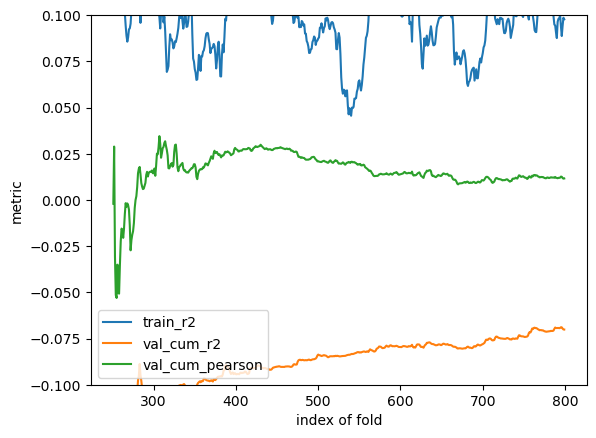

In [98]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-0.1, 0.1])
plt.show()

In [99]:
from pipeline.backtest import AugmentationOption

performance = evaluation_for_submission(model, feature, dataset=dataset, qids=qids, lookback_window=50,
                                        option=AugmentationOption(market_return=False))

Day 1700, test cum pearson 0.0053: 100%|█████████▉| 699/700 [06:23<00:00,  1.82it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: 7.9029e-02
The ending score for metric test_cum_r2 is: -6.0910e-02
The ending score for metric test_cum_pearson is: 5.3445e-03


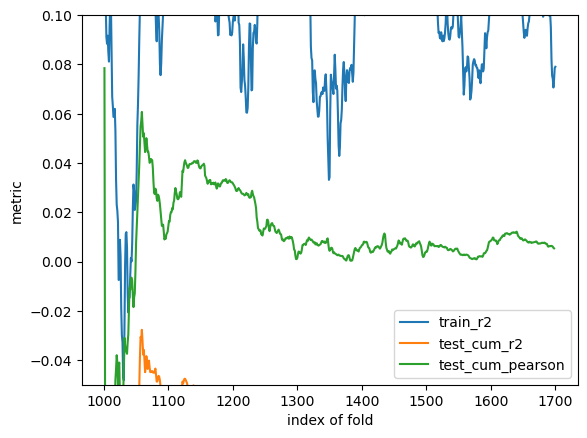

In [100]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.show()

In [14]:
aa = DataPreprocessing().fit_transform(df[feature])

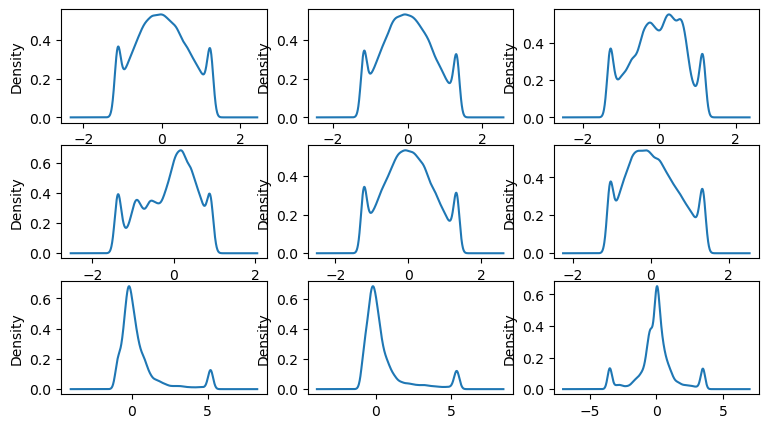

In [15]:
fig, axs = plt.subplots(len(aa.columns) // 3, 3, figsize=(9, 5))
for ax, col in zip(axs.flat, aa.columns):
    aa[col].plot(ax=ax, kind='kde')

In [7]:
from datatools import calculate_market_return

market_return = calculate_market_return(df)
fdf = full_df.merge(market_return, left_on='day', right_index=True)

In [12]:
fdf['return_0'].corr(fdf['market_return_0'])

0.7055823631689073

In [14]:
[market_return.autocorr(i) for i in [1, 2, 3]]

[0.07335182088226597, -0.0787376280186052, -0.015705546147832667]

In [15]:
market_return.rolling(5).mean()

day
1            NaN
2            NaN
3            NaN
4            NaN
5       0.007175
          ...   
996     0.000443
997    -0.000488
998    -0.000073
999    -0.003122
1000   -0.003916
Name: market_return_0, Length: 1000, dtype: float64

In [19]:
mr_df = DataFrame({
    'target': market_return.shift(-2),
    'return_0': market_return,
    'return_1': market_return.shift(1),
    'return_2': market_return.shift(2),
    'return_3': market_return.shift(3),
    'return_4': market_return.shift(4),
    'rolling_5': market_return.rolling(5).mean(),
    'rolling_s5': market_return.rolling(5).std(),
    'rolling_10': market_return.rolling(10).mean(),
    'rolling_s10': market_return.rolling(10).std(),
    'ewm_2': market_return.ewm(halflife=2).mean(),
    'ewm_s2': market_return.ewm(halflife=2).std(),
    'ewm_5': market_return.ewm(halflife=5).mean(),
    'ewm_s5': market_return.ewm(halflife=5).std(),
    'ewm_10': market_return.ewm(halflife=10).mean(),
    'ewm_s10': market_return.ewm(halflife=10).std(),
}).dropna()
mr_df['asset'] = 0
mr_df = mr_df.reset_index().set_index(['day', 'asset'])
mr_df

,,target,return_0,return_1,return_2,return_3,return_4,rolling_5,rolling_s5,rolling_10,rolling_s10,ewm_2,ewm_s2,ewm_5,ewm_s5,ewm_10,ewm_s10
day,asset,,,,,,,,,,,,,,,,
10,0,0.009161,0.011614,-0.008722,-0.008473,-0.005088,-0.007031,-0.003540,0.008594,0.001817,0.013865,0.001229,0.012448,0.001517,0.013218,0.001696,0.013546
11,0,0.009953,-0.009017,0.011614,-0.008722,-0.008473,-0.005088,-0.003937,0.008838,0.001609,0.014026,-0.001840,0.011616,-0.000226,0.012718,0.000351,0.013147
12,0,-0.041415,0.009161,-0.009017,0.011614,-0.008722,-0.008473,-0.001087,0.010513,0.003671,0.013392,0.001433,0.011192,0.001273,0.012171,0.001396,0.012651
13,0,0.034440,0.009953,0.009161,-0.009017,0.011614,-0.008722,0.002598,0.010506,0.003941,0.013499,0.003956,0.010312,0.002619,0.011636,0.002361,0.012209
14,0,0.023181,-0.041415,0.009953,0.009161,-0.009017,0.011614,-0.003941,0.022565,-0.003134,0.016839,-0.009437,0.024363,-0.004037,0.019711,-0.002360,0.018219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0.001040,0.003083,-0.009745,0.005173,0.014558,-0.004799,0.001654,0.009388,0.002678,0.009900,0.001672,0.009385,0.002331,0.010396,0.001690,0.011583
995,0,0.000516,0.002665,0.003083,-0.009745,0.005173,0.014558,0.003147,0.008671,0.003225,0.009713,0.001963,0.007908,0.002374,0.009700,0.001755,0.011192
996,0,-0.007671,0.001040,0.002665,0.003083,-0.009745,0.005173,0.000443,0.005883,0.002906,0.009728,0.001693,0.006666,0.002201,0.009062,0.001707,0.010812


In [21]:
features = ['return_0', 'return_1', 'return_2', 'return_3', 'return_4', 'rolling_5', 'rolling_s5', 'rolling_10',
            'rolling_s10', 'ewm_2', 'ewm_s2', 'ewm_5', 'ewm_s5', 'ewm_10', 'ewm_s10']
X = mr_df[features]
y = mr_df['target']

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.029866510621826325

In [34]:
class JustLinearModel:
    def __init__(self):
        self.reg = LinearRegression()

    def fit_predict(self, X, y):
        self.reg.fit(X, y)
        return self.reg.predict(X)

    def predict(self, X):
        return np.clip(self.reg.predict(X), -0.1, 0.1)

In [35]:
model = JustLinearModel()
performance, cum_y_df = cross_validation(model, features, mr_df, return_column='target', train_lookback=30)

  0%|          | 0/958 [00:00<?, ?it/s]/home/xdroid/repo/qids-2023-comp/pipeline/backtest.py:76: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  X_train = df.loc[idx[days_train, :], :][feature_columns]
/home/xdroid/repo/qids-2023-comp/pipeline/backtest.py:77: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  y_train_true = df.loc[idx[days_train[per_eval_lookback - 1:], :], return_column]
/opt/miniconda3/envs/qids-2023-comp/lib/python3.9/sit

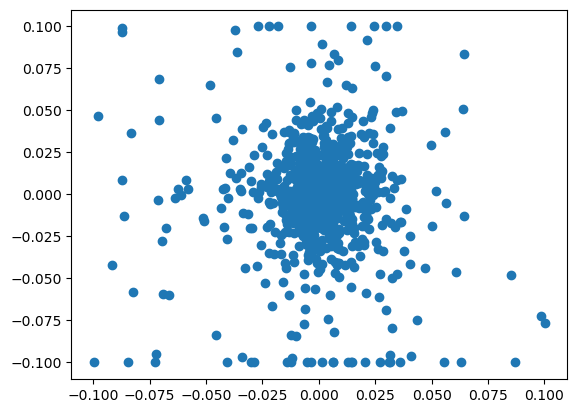

In [36]:
plt.scatter(cum_y_df.cum_y_val_true, cum_y_df.cum_y_val_prediction)

The ending score for metric train_r2 is: 3.1983e-01
The ending score for metric val_cum_r2 is: -1.0257e+00
The ending score for metric val_cum_pearson is: -7.2840e-02


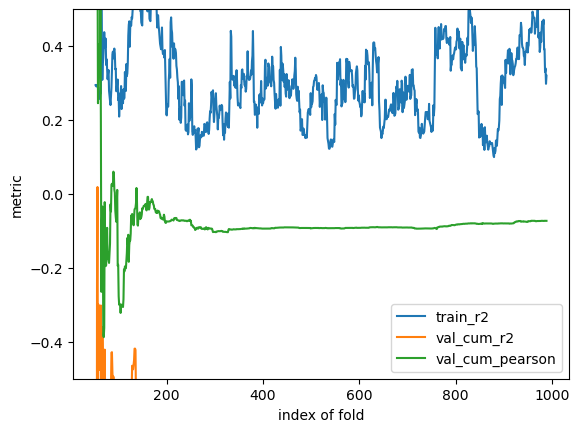

In [25]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.ylim([-0.5, 0.5])
plt.show()